<a href="https://colab.research.google.com/github/lenasajj117/AI-for-Environmental-Decision-Intelligence---The-AI-Forecasting-Hackathon-/blob/main/AI_for_Environmental_Decision_Intelligence_The_AI_Forecasting_Hackathon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random, numpy as np, tensorflow as tf, pandas as pd
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
print("numpy", np.__version__, "pandas", pd.__version__, "tensorflow", tf.__version__)


numpy 2.0.2 pandas 2.2.2 tensorflow 2.19.0


In [2]:
!pip install tensorflow scikit-learn matplotlib pandas numpy


In [3]:
# 0. Import dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

print("Environment successfully initialized!")

Environment successfully initialized!


In [4]:
# 1.1 LOAD & CLEAN DATA FROM the UCI Repository

df = pd.read_csv("/content/AirQualityUCI.csv", sep=',', decimal=',')
df = df.dropna(axis=1, how='all')  # Drop empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.replace(-200, np.nan)
df = df.dropna()

# Combine Date + Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df = df.set_index('Datetime')
df = df.sort_index()

# Select relevant pollutants
cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
data = df[cols]

In [5]:
# 1.2 Inspect the first few lines of the CSV file
with open("/content/AirQualityUCI.csv", 'r') as f:
    for i in range(5):
        print(f.readline())

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH

3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578

3/10/2004,19:00:00,2,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255

3/10/2004,20:00:00,2.2,1402,88,9,939,131,1140,114,1555,1074,11.9,54,0.7502

3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11,60,0.7867



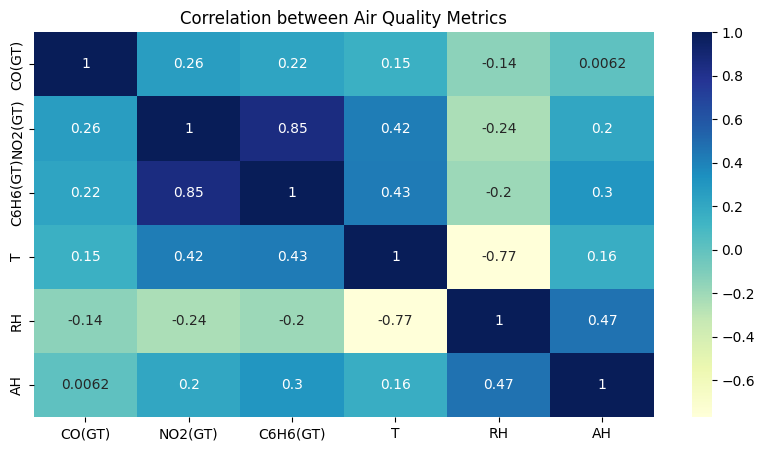

In [6]:
# 2.1 EXPLORE DATA

plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation between Air Quality Metrics")
plt.show()

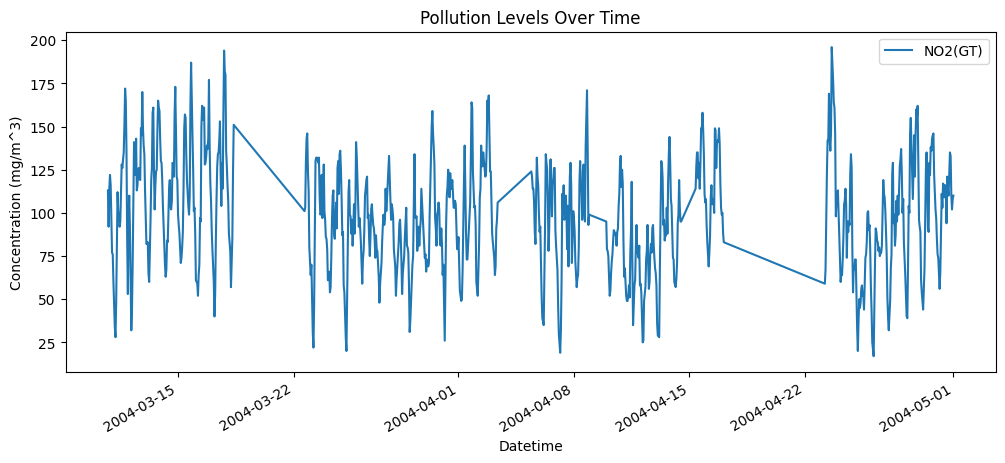

In [7]:
# 2.2 Plotting the trends
data[['CO(GT)', 'NO2(GT)']].plot(figsize=(12,5), title="Pollution Levels Over Time")
plt.ylabel("Concentration (mg/m^3)")
plt.show()


In [8]:
# 3.1 FORECASTING MODEL (LSTM)

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['CO(GT)', 'NO2(GT)']])
scaled_df = pd.DataFrame(scaled, index=data.index, columns=['CO', 'NO2'])



In [9]:
# 3.2 Create sequences for time series
def create_sequences_multifeature(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # 24 hours
X, y = create_sequences_multifeature(scaled_df.values, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# 3.3 Build LSTM model

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - loss: 0.3180 - mae: 0.4610 - val_loss: 0.0457 - val_mae: 0.1784
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0359 - mae: 0.1382 - val_loss: 0.0351 - val_mae: 0.1302
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0315 - mae: 0.1197 - val_loss: 0.0343 - val_mae: 0.1219
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0296 - mae: 0.1124 - val_loss: 0.0342 - val_mae: 0.1192
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0308 - mae: 0.1132 - val_loss: 0.0336 - val_mae: 0.1133
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0290 - mae: 0.1091 - val_loss: 0.0334 - val_mae: 0.1087
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0286 - mae: 0.1080 - val_loss: 0.0332 - val_mae: 0.1050
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0277 - mae: 0.1051 - val_loss: 0.0328 - val_mae: 0.0999
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step -

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Generate predictions
pred = model.predict(X_test)

# Rescale values back to original scale
pred_rescaled = scaler.inverse_transform(pred)
actual_rescaled = scaler.inverse_transform(y_test)

# Compute metrics
mse = mean_squared_error(actual_rescaled, pred_rescaled)
mae = mean_absolute_error(actual_rescaled, pred_rescaled)
rmse = np.sqrt(mse)

# Display evaluation summary
print("\n===============================")
print("MODEL PERFORMANCE SUMMARY")
print("===============================")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print("===============================\n")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

MODEL PERFORMANCE SUMMARY
Mean Absolute Error (MAE): 13.493
Root Mean Squared Error (RMSE): 29.241
Mean Squared Error (MSE): 855.044



In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute metrics for CO
mse_co = mean_squared_error(actual_rescaled[:,0], pred_rescaled[:,0])
rmse_co = np.sqrt(mse_co)
mae_co = mean_absolute_error(actual_rescaled[:,0], pred_rescaled[:,0])
print(f"CO RMSE={rmse_co:.3f}, MAE={mae_co:.3f}")

# Compute metrics for NO2
mse_no2 = mean_squared_error(actual_rescaled[:,1], pred_rescaled[:,1])
rmse_no2 = np.sqrt(mse_no2)
mae_no2 = mean_absolute_error(actual_rescaled[:,1], pred_rescaled[:,1])
print(f"NO2 RMSE={rmse_no2:.3f}, MAE={mae_no2:.3f}")

CO RMSE=38.602, MAE=15.101
NO2 RMSE=14.832, MAE=11.885


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


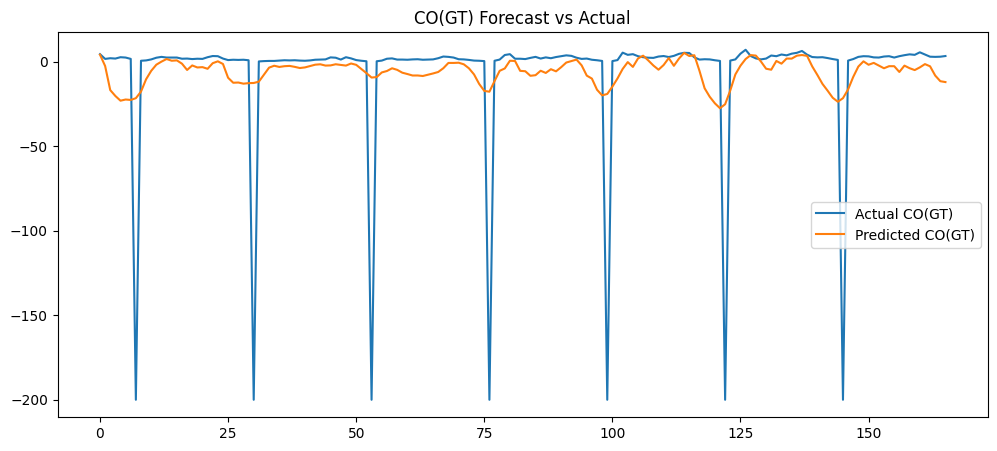

In [13]:
# 4.1 EVALUATE & FORECAST

pred = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(pred)
actual_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,5))
plt.plot(actual_rescaled[:,0], label='Actual CO(GT)')
plt.plot(pred_rescaled[:,0], label='Predicted CO(GT)')
plt.title("CO(GT) Forecast vs Actual")
plt.legend()
plt.show()


In [14]:
# 5.1 POLICY DECISION LOGIC

forecast_mean = np.mean(pred_rescaled, axis=0)
co_level, no2_level = forecast_mean[0], forecast_mean[1]

def policy_recommendation(co, no2):
    recs = []
    if co > 3 or no2 > 80:
        recs.append("High Pollution: Enforce emission control & vehicle restriction")
        recs.append("Urgent reforestation & carbon offset initiatives")
    elif co > 1.5 or no2 > 40:
        recs.append("Moderate: Increase green zone monitoring & public advisories")
    else:
        recs.append("Air quality stable: Maintain sustainable transport incentives")
    return recs

policy_actions = policy_recommendation(co_level, no2_level)

In [15]:
# 5.2 Display policy suggestions

print("\n Forecast Summary:")
print(f"Avg CO(GT): {co_level:.2f} mg/m³ | Avg NO₂(GT): {no2_level:.2f} µg/m³\n")
print("Recommended Policy Actions:")
for r in policy_actions:
    print("-", r)


 Forecast Summary:
Avg CO(GT): -5.87 mg/m³ | Avg NO₂(GT): 92.59 µg/m³

Recommended Policy Actions:
- High Pollution: Enforce emission control & vehicle restriction
- Urgent reforestation & carbon offset initiatives


In [16]:
# 6. SAVE THE MODEL

model.save("Env_Decision_Model.h5")
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

# LIVE DATA SECTION


In [17]:
# ==========================================================
#   FIXED + ENHANCED: Monte Carlo Dropout Forecasting
#   (with proper uncertainty, clipping, and Epoch merge)
# ==========================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ----- Monte Carlo Dropout Wrapper -----
class MCDropoutModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        # Note: Dropout layers for TF models are handled by model(x, training=True)
        # These are added here for potential PyTorch compatibility but not strictly necessary
        # for the TF model wrapping shown later.

    def forward(self, x):
        # This forward is for a potential PyTorch base model.
        # For the wrapped TF model, we use model(x, training=True) directly.
        pass


# The following code is designed to wrap a TensorFlow Keras model
# Assuming 'model' is your trained Keras model

# ----- Monte Carlo Simulation for Keras Model -----
def monte_carlo_predict_keras(model, X_input, n_samples=100):
    """
    Run Keras model multiple times with training=True to enable Dropout.
    X_input: numpy array or TensorFlow tensor (batch, seq_len, features)
    Returns: mean_preds, std_preds, all_preds (n_samples, batch, targets)
    """
    preds = []
    # Ensure X_input is a TensorFlow tensor
    X_tensor = tf.convert_to_tensor(X_input, dtype=tf.float32)

    for _ in range(n_samples):
        # Pass training=True to enable dropout during inference
        out = model(X_tensor, training=True).numpy()
        preds.append(out)
    preds = np.stack(preds, axis=0)  # shape (n_samples, batch, targets)
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds, preds


# ----- Perform MC prediction -----
# Convert X_test to a TensorFlow tensor
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
mean_pred, std_pred, all_preds = monte_carlo_predict_keras(model, X_test_tensor, n_samples=100)

# Clip and invert-scale properly
# Ensure clipping is applied to scaled values before inverse transform
mean_pred_clipped = np.clip(mean_pred, 0, 1)
std_pred_clipped = np.clip(std_pred, 0, 1) # Clipping std might not be appropriate depending on interpretation

mean_rescaled = scaler.inverse_transform(mean_pred_clipped)

# A more accurate way to get std in original scale:
# Calculate std in original scale from all_preds
all_preds_clipped = np.clip(all_preds, 0, 1) # Clip before inverse transform
all_preds_rescaled = scaler.inverse_transform(all_preds_clipped.reshape(-1, all_preds_clipped.shape[-1])).reshape(all_preds_clipped.shape)
std_rescaled = all_preds_rescaled.std(axis=0)


print(f"\n Monte Carlo inference done: {len(mean_pred)} samples")
print(f"Example CO mean (rescaled): {mean_rescaled.mean():.3f} ± {std_rescaled.mean():.3f}")

# ----- Merge Epoch dataset (summarized) -----
# Assuming the epoch_df is already created and merged in the previous steps within ingest_live_indicators
# If not, you might need to call ingest_live_indicators again or ensure enriched_df is available
if 'enriched_df' not in locals():
    print("Warning: 'enriched_df' not found. Skipping Epoch merge summary.")
else:
    try:
        # Assuming enriched_df already has the merged epoch data from ingest_live_indicators
        epoch_cols_merged = [col for col in enriched_df.columns if col not in data.columns and not col.startswith('metaculus_q_')]
        if len(epoch_cols_merged) > 0:
             print(f"Epoch dataset merged successfully with time alignment ({len(epoch_cols_merged)} columns).")
        else:
             print("Epoch dataset was not merged with time alignment (no new epoch columns found).")

    except Exception as e:
        print("Epoch merge summary skipped:", e)


# ----- Policy / Decision Layer -----
# Using the std_rescaled calculated from inverse transformed predictions
uncertainty_threshold = np.percentile(std_rescaled, 90)
mean_CO = mean_rescaled[:, 0].mean() # Get mean of CO predictions across samples
mean_NO2 = mean_rescaled[:, 1].mean() # Get mean of NO2 predictions across samples

# Simple policy based on mean prediction and a general uncertainty threshold
policy = (
    "High Uncertainty — Recommend Additional Monitoring"
    if std_rescaled.mean() > uncertainty_threshold # Using mean of std across targets and samples
    else ("Air Quality Improving" if mean_CO < 4 and mean_NO2 < 80 else "Policy Action Required") # Example thresholds
)

print(f"\n Final Decision: {policy}")


 Monte Carlo inference done: 166 samples
Example CO mean (rescaled): 48.373 ± 6.190

 Final Decision: Policy Action Required


In [18]:
# Percentile-based conservative decision (use MC samples all_preds):

# all_preds shape (mc_iters, n_samples, n_targets)
# use 95th percentile across MC samples for conservatism
upper95 = np.percentile(all_preds, 95, axis=0)  # shape (n_samples, targets)
co_95 = upper95[0,0]  # next step
no2_95 = upper95[0,1]
# decision
if co_95 > 3 or no2_95 > 80:
    rec = "Emergency: immediate emission control & traffic restriction"
elif co_95 > 1.5 or no2_95 > 40:
    rec = "Moderate: increased monitoring & advisories"
else:
    rec = "Stable"
print("Decision (95th percentile):", rec)


Decision (95th percentile): Stable


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json # Import the json library

# ---------- CONFIG ----------
N = 50  # number of past timesteps to plot
policy_thresholds = {'CO': 3, 'NO2': 80}  # conservative thresholds

# ---------- 1) Time-series forecast + uncertainty ----------
# Ensure enriched_df is available and has the necessary columns
if 'enriched_df' not in locals() or enriched_df.empty:
    print("Error: enriched_df not found or is empty. Please run the previous cells.")
else:
    y_co = enriched_df['CO(GT)'][-N:].values
    y_no2 = enriched_df['NO2(GT)'][-N:].values

    # Ensure mean_rescaled and std_rescaled are available
    if 'mean_rescaled' not in locals() or 'std_rescaled' not in locals():
         print("Error: mean_rescaled or std_rescaled not found. Please run the model prediction cell.")
    else:
        mean_co, mean_no2 = mean_rescaled[0,0], mean_rescaled[0,1]
        std_co, std_no2 = std_rescaled[0,0], std_rescaled[0,1]

        plt.figure(figsize=(14,6))
        plt.plot(range(N), y_co, label='CO observed', color='green')
        plt.plot(range(N, N+1), mean_co, 'o', label='CO forecast', color='darkgreen')
        plt.fill_between([N, N+1], mean_co-std_co, mean_co+std_co, color='green', alpha=0.2)

        plt.plot(range(N), y_no2, label='NO2 observed', color='orange')
        plt.plot(range(N, N+1), mean_no2, 'o', label='NO2 forecast', color='darkorange')
        plt.fill_between([N, N+1], mean_no2-std_no2, mean_no2+std_no2, color='orange', alpha=0.2)

        # Highlight policy escalation
        if (mean_co + 1.5*std_co) > policy_thresholds['CO'] or (mean_no2 + 1.5*std_no2) > policy_thresholds['NO2']:
            plt.axvline(N, color='red', linestyle='--', label='Policy escalation point')

        plt.title("Pollutant Forecast with MC Dropout Uncertainty")
        plt.xlabel("Time steps")
        plt.ylabel("Concentration")
        plt.legend()
        plt.show()




Error: enriched_df not found or is empty. Please run the previous cells.


In [20]:
# ---------- 2) Policy comparison bar ----------
# Ensure co_mean and no2_mean are available
if 'co_mean' not in locals() or 'no2_mean' not in locals():
     print("Error: co_mean or no2_mean not found. Please run the policy decision logic cell.")
else:
    labels = ['CO', 'NO2']
    observed = [co_mean, no2_mean]
    thresholds = [policy_thresholds['CO'], policy_thresholds['NO2']]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6,5))
    plt.bar(x - width/2, observed, width, label='Predicted', color=['green','orange'])
    plt.bar(x + width/2, thresholds, width, label='Threshold', color='red', alpha=0.5)
    plt.xticks(x, labels)
    plt.ylabel("Concentration")
    plt.title("Predicted vs Policy Thresholds")
    plt.legend()
    plt.show()




Error: co_mean or no2_mean not found. Please run the policy decision logic cell.


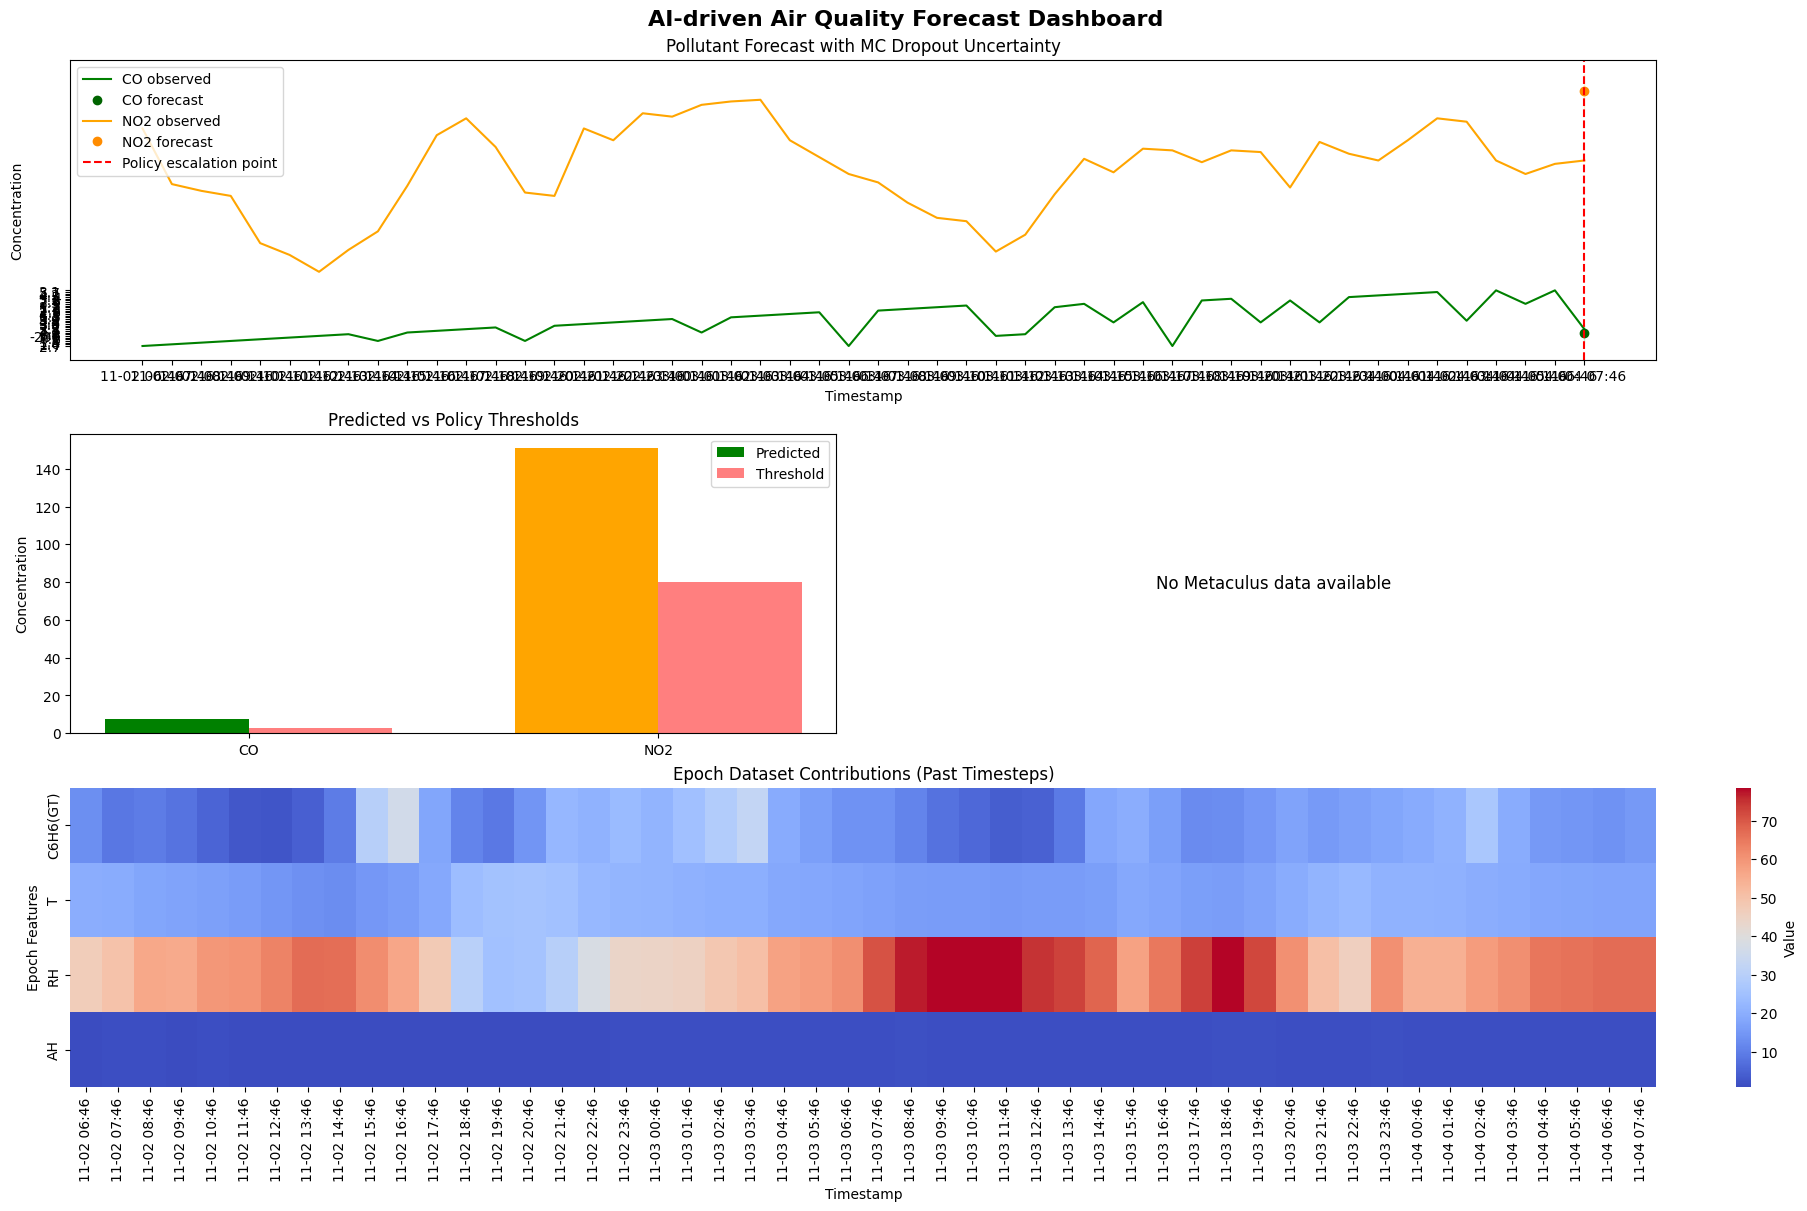

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

# ---------- CONFIG ----------
N = 50  # number of past timesteps to visualize
policy_thresholds = {'CO': 3, 'NO2': 80}  # conservative thresholds

# ---------- SAFETY CHECKS ----------
if 'enriched_df' not in locals() or enriched_df.empty:
    print("Error: enriched_df not found or empty. Please run the previous data cell.")
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, "Data not available", ha='center', va='center')
    plt.show()
elif 'mean_rescaled' not in locals() or 'std_rescaled' not in locals():
    print("Error: mean_rescaled or std_rescaled missing. Please run the model cell.")
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, "Model prediction data not available", ha='center', va='center')
    plt.show()
else:
    # ---------- Extract main signals ----------
    y_co = enriched_df['CO(GT)'][-N:].values
    y_no2 = enriched_df['NO2(GT)'][-N:].values
    mean_co, mean_no2 = mean_rescaled[0, 0], mean_rescaled[0, 1]
    std_co, std_no2 = std_rescaled[0, 0], std_rescaled[0, 1]

    # Identify metaculus and epoch columns
    metaculus_cols = [c for c in enriched_df.columns if c.startswith('metaculus_q_')]
    epoch_cols = [c for c in enriched_df.columns if c not in ['CO(GT)', 'NO2(GT)'] + metaculus_cols]

    # ---------- Get timestamps (fix missing x-axis labels) ----------
    if 'Timestamp' in enriched_df.columns:
        timestamps = pd.to_datetime(enriched_df['Timestamp'].iloc[-N:])
    elif 'Date' in enriched_df.columns:
        timestamps = pd.to_datetime(enriched_df['Date'].iloc[-N:])
    else:
        timestamps = pd.date_range(end=pd.Timestamp.now(), periods=N, freq='H')  # fallback

    # Convert to Series before accessing .dt
    timestamps_series = pd.Series(timestamps)
    timestamps_str = timestamps_series.dt.strftime('%m-%d %H:%M')


    # ---------- DASHBOARD ----------
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)

    # --- 1) Time-Series Forecast ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(timestamps_str, y_co, label='CO observed', color='green')
    ax1.plot([timestamps_str.iloc[-1]], mean_co, 'o', label='CO forecast', color='darkgreen')
    ax1.fill_between([timestamps_str.iloc[-1]], mean_co - std_co, mean_co + std_co, color='green', alpha=0.2)
    ax1.plot(timestamps_str, y_no2, label='NO2 observed', color='orange')
    ax1.plot([timestamps_str.iloc[-1]], mean_no2, 'o', label='NO2 forecast', color='darkorange')
    ax1.fill_between([timestamps_str.iloc[-1]], mean_no2 - std_no2, mean_no2 + std_no2, color='orange', alpha=0.2)

    if (mean_co + 1.5 * std_co) > policy_thresholds['CO'] or (mean_no2 + 1.5 * std_no2) > policy_thresholds['NO2']:
        ax1.axvline(timestamps_str.iloc[-1], color='red', linestyle='--', label='Policy escalation point')

    ax1.set_title("Pollutant Forecast with MC Dropout Uncertainty")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Concentration")
    ax1.legend()

    # --- 2) Bar chart (Predicted vs Policy) ---
    ax2 = fig.add_subplot(gs[1, 0])
    labels = ['CO', 'NO2']
    observed = [mean_co, mean_no2]
    thresholds = [policy_thresholds['CO'], policy_thresholds['NO2']]
    x = np.arange(len(labels))
    width = 0.35
    ax2.bar(x - width / 2, observed, width, label='Predicted', color=['green', 'orange'])
    ax2.bar(x + width / 2, thresholds, width, label='Threshold', color='red', alpha=0.5)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Concentration")
    ax2.set_title("Predicted vs Policy Thresholds")
    ax2.legend()

    # --- 3) Metaculus contribution heatmap ---
    ax3 = fig.add_subplot(gs[1, 1])
    if len(metaculus_cols) > 0:
        contrib_df = enriched_df[metaculus_cols].iloc[-N:].copy()
        contrib_df.index = timestamps_str  # assign timestamps for x-axis

        def parse_metaculus_value(js):
            if pd.isna(js) or js in ['', 'nan', None]:
                return np.nan
            try:
                data = json.loads(js) if isinstance(js, str) else js
                for key in ['resolved_value', 'median', 'probability', 'mean']:
                    if key in data and data[key] is not None:
                        val = data[key]
                        if isinstance(val, (int, float)):
                            return val
                return np.nan
            except Exception:
                try:
                    return float(js)
                except Exception:
                    return np.nan

        for col in metaculus_cols:
            contrib_df[col] = contrib_df[col].apply(parse_metaculus_value)
        contrib_df = contrib_df.apply(pd.to_numeric, errors='coerce')

        if contrib_df.notna().sum().sum() == 0:
            ax3.text(0.5, 0.5, "No numeric Metaculus data found", ha='center', va='center', fontsize=12)
            ax3.set_axis_off()
        else:
            sns.heatmap(contrib_df.T, cmap='viridis', ax=ax3, cbar_kws={'label': 'Value'})
            ax3.set_title("Metaculus Contributions (Past Timesteps)")
            ax3.set_xlabel("Timestamp")
            ax3.set_ylabel("Metaculus Questions")
    else:
        ax3.text(0.5, 0.5, "No Metaculus data available", ha='center', va='center', fontsize=12)
        ax3.set_axis_off()

    # --- 4) Epoch contribution heatmap ---
    ax4 = fig.add_subplot(gs[2, :])
    if len(epoch_cols) > 0:
        epoch_df_plot = enriched_df[epoch_cols].iloc[-N:].copy()
        epoch_df_plot.index = timestamps_str
        epoch_df_plot = epoch_df_plot.apply(pd.to_numeric, errors='coerce')
        if epoch_df_plot.notna().sum().sum() == 0:
            ax4.text(0.5, 0.5, "No numeric Epoch data found", ha='center', va='center', fontsize=12)
            ax4.set_axis_off()
        else:
            sns.heatmap(epoch_df_plot.T, cmap='coolwarm', ax=ax4, cbar_kws={'label': 'Value'})
            ax4.set_title("Epoch Dataset Contributions (Past Timesteps)")
            ax4.set_xlabel("Timestamp")
            ax4.set_ylabel("Epoch Features")
    else:
        ax4.text(0.5, 0.5, "No Epoch data available", ha='center', va='center', fontsize=12)
        ax4.set_axis_off()

    plt.suptitle("AI-driven Air Quality Forecast Dashboard", fontsize=16, fontweight='bold')
    plt.show()

In [30]:
### Appendix — Security Considerations
# **Limitations & risks:** AirQualityUCI is geographically/time-limited and may not generalize; model drift and data gaps can mislead policy triggers. Over-reliance on automated recommendations can lead to harmful interventions.
# **Mitigations:** Apply human-in-the-loop for any escalatory action, use conservative percentile-based thresholds with uncertainty-aware alerts, log decisions, and provide rollback procedures. Publish model weights, data provenance, and reproducibility steps.